In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Exploring UK Biobank data and relating it to mean activity

In [2]:
from accel.read_data import load_data, get_numeric_cols, get_object_cols
from accel.constants import DATA_DIR

In [3]:
# Features from biobank
raw_data = load_data(DATA_DIR / "shared/reduced-cohort.csv") # can also see biobank-encoded-cohort
# raw_data = load_data(PATH+'biobank-encoded-cohort.csv') # can also see biobank-encoded-cohort

In [4]:
raw_data.shape

(99413, 70)

There are quite a few features in this data-set(70 = 69 features + 1 reponse)! We have 99413 observations in this data-set, though we still need to check for missingness. The response we are looking at is `acc.overall.avg` which takes the mean of the accelerometer data. The accelerometer data is time series data which measures the acceleration experienced by the device in x, y and z directions relative to the device which is worn on the participant's wrist. 

We preview the first few rows below:

In [5]:
raw_data.head()

,Unnamed: 0,acc.overall.avg,Participant ID,MET minutes per week for vigorous activity | Instance 0,Tea intake | Instance 0,Sex,Type of accommodation lived in | Instance 0,Duration of walks | Instance 0,Frequency of stair climbing in last 4 weeks | Instance 0,Getting up in morning | Instance 0,...,Attendance/disability/mobility allowance | Instance 0,Ethnic background | Instance 0,Crime score,Education score,Employment score,Health score,Housing score,Income score,Index of Multiple Deprivation,Living environment
0,0,24.20244,1000052,960.0,4,Female,A house or bungalow,40,1-5 times a day,Fairly easy,...,None of the above,British,-0.55,23.89,0.12,-0.33,6.90,0.19,18.76,8.70
1,1,31.56829,1000133,320.0,8,Male,A house or bungalow,30,11-15 times a day,Fairly easy,...,None of the above,British,1.46,22.17,0.08,0.43,28.64,0.09,22.82,11.35
2,2,31.81727,1000209,1920.0,2,Male,A house or bungalow,60,16-20 times a day,Fairly easy,...,None of the above,British,-0.70,10.13,0.08,0.16,22.16,0.04,10.10,1.64
3,3,23.68884,1000297,0.0,7,Male,A house or bungalow,30,6-10 times a day,Very easy,...,None of the above,British,0.96,7.07,0.11,0.23,32.34,0.17,27.22,42.53
4,4,18.83354,1000384,3600.0,2,Male,A house or bungalow,20,11-15 times a day,Very easy,...,None of the above,Any other white background,-1.18,1.49,0.06,-0.32,5.69,0.04,4.60,5.79


# Exploring the response variable
The response variable, acc.overall.avg, takes the norm of the the three acceleration channels and averages it over time. Measurements are relative to the acceleration due to gravity, and since most of the time we experience 1G downwards, they subtract 1 from the variable. We want to see whether there are any outliers in the distribution of the response.

0.0 2262.2734600000003


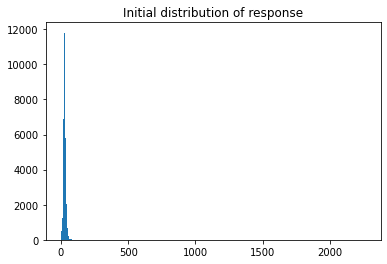

In [6]:
all_y = raw_data["acc.overall.avg"]
plt.hist(all_y, 1000)
plt.title("Initial distribution of response")
print(np.min(all_y),np.max(all_y))

As we can see, the physical activity is very peaked towards 0. There are likely outliers in it. It has been suggested that we filter out all observations with y > 100. 

By removing all values above 100 we are left with 99382 out of 99413 observations.


Text(0.5, 1.0, 'Distribution of response post cutoff')

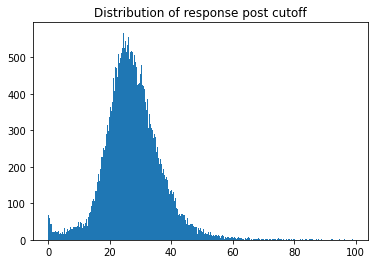

In [7]:
cutoff = 100
y = all_y[all_y<cutoff]
print(f"By removing all values above {cutoff} we are left with {len(y)} out of {len(all_y)} observations.")
plt.hist(y, 1000)
plt.title("Distribution of response post cutoff")

We might also be interested in looking at the response on a log scale

Text(0.5, 1.0, 'Distribution of response post cutoff')

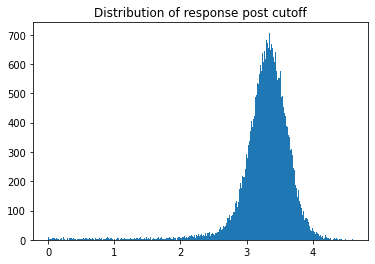

In [8]:
plt.hist(np.log(1+y), 1000)
plt.title("Distribution of response post cutoff")

## Defining features
We define the categorical and numerical features and get rid of columns such as the participant ID and the index. Upon exploring the categorical and numerical features, it appears that it might be worth further defining genres of similar features, and that it might not be a good idea to include all variables without reflecting on their encoding and meaning further. To what extent is our data-set representative and which categories might be under-represented in our data?

In [9]:
set(raw_data.columns)

{'Above moderate/vigorous recommendation | Instance 0',
 'Above moderate/vigorous/walking recommendation | Instance 0',
 'Age at recruitment',
 'Age started wearing glasses or contact lenses | Instance 0',
 'Alcohol drinker status | Instance 0',
 'Alcohol intake frequency. | Instance 0',
 'Attendance/disability/mobility allowance | Instance 0',
 'Average total household income before tax | Instance 0',
 'Blood clot, DVT, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor | Instance 0',
 'Body mass index (BMI) | Instance 0',
 'Breastfed as a baby | Instance 0',
 'Cancer diagnosed by doctor | Instance 0',
 'Chest pain or discomfort | Instance 0',
 'Cooked vegetable intake | Instance 0',
 'Crime score',
 'Diabetes diagnosed by doctor | Instance 0',
 'Duration of walks | Instance 0',
 'Education score',
 'Employment score',
 'Ethnic background | Instance 0',
 'Exposure to tobacco smoke at home | Instance 0',
 'Exposure to tobacco smoke outside home | Instance 0',


In [10]:
features_of_interest = list(set(raw_data.columns) - set(['Unnamed: 0', 'Participant ID', 'acc.overall.avg']))

# identify the categorical features
categorical_features = get_object_cols(raw_data[features_of_interest])
        
# indentify the numerical features
numeric_features = get_numeric_cols(raw_data[features_of_interest])

In [11]:
set(categorical_features)

{'Above moderate/vigorous recommendation | Instance 0',
 'Above moderate/vigorous/walking recommendation | Instance 0',
 'Age started wearing glasses or contact lenses | Instance 0',
 'Alcohol drinker status | Instance 0',
 'Alcohol intake frequency. | Instance 0',
 'Attendance/disability/mobility allowance | Instance 0',
 'Average total household income before tax | Instance 0',
 'Blood clot, DVT, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor | Instance 0',
 'Breastfed as a baby | Instance 0',
 'Cancer diagnosed by doctor | Instance 0',
 'Chest pain or discomfort | Instance 0',
 'Cooked vegetable intake | Instance 0',
 'Diabetes diagnosed by doctor | Instance 0',
 'Duration of walks | Instance 0',
 'Ethnic background | Instance 0',
 'Exposure to tobacco smoke at home | Instance 0',
 'Exposure to tobacco smoke outside home | Instance 0',
 'Fractured/broken bones in last 5 years | Instance 0',
 'Frequency of stair climbing in last 4 weeks | Instance 0',
 '

In [12]:
set(numeric_features)

{'Age at recruitment',
 'Body mass index (BMI) | Instance 0',
 'Crime score',
 'Education score',
 'Employment score',
 'Health score',
 'Housing score',
 'Income score',
 'Index of Multiple Deprivation',
 'Living environment',
 'MET minutes per week for moderate activity | Instance 0',
 'MET minutes per week for vigorous activity | Instance 0',
 'MET minutes per week for walking | Instance 0',
 'Summed days activity | Instance 0',
 'Townsend deprivation index at recruitment'}

## Thoughts!

It seems that some of the categorical variables, such as `Time spend outdoors in summer`, might be numerical in nature and some of the numerical variables, such as `living environment`, might be categorical in nature. 

There are also some variables whose relevance are note immediately obvious to predicting physical activity such as:
- How are people in household related to participant
- Age started wearing glasses or contact lenses | Instance 0 
- Mouth/teeth dental problems | Instance 0'

It might make sense to manually group variables into categories such as:

Categorical prefeaced with *C*, 
Numerical prefaced with *N* 
(! denotes items which should be looked into further): 

- emotional
    - C Irritability | Instance 0
    - C Miserableness | Instance 0
    - C Mood swings | Instance 0
    - C Sensitivity / hurt feelings | Instance 0
    - C Worrier / anxious feelings | Instance 0
- dietary 
    - C! Cooked vegetable intake | Instance 0
    - C! Fresh fruit intake | Instance 0
    - C! Oily fish intake | Instance 0
    - C Salad / raw vegetable intake | Instance 0
    - C Salt added to food | Instance 0
    - C! Tea intake | Instance 0
    - C! Water intake | Instance 0
- socio
    - C! Average total household income before tax | Instance 0
    - C Ethnic background | Instance 0
    - C! Number of vehicles in household | Instance 0
    - C Qualifications | Instance 0
    - C Sex
    - C Type of accommodation lived in | Instance 0
    - N Age at recruitment
    - N Crime score
    - N Education score
    - N Employment score
    - N Housing score
    - N Income score
    - N Index of Multiple Deprivation
    - N! Living environment
    - N Townsend deprivation index at recruitment
- physical
    - C Above moderate/vigorous recommendation | Instance 0
    - C Above moderate/vigorous/walking recommendation | Instance 0
    - C Attendance/disability/mobility allowance | Instance 0
    - C! Duration of walks | Instance 0
    - C! Frequency of stair climbing in last 4 weeks | Instance 0
    - C! Frequency of tiredness / lethargy in last 2 weeks | Instance 0
    - C IPAQ activity group | Instance 0
    - N Body mass index (BMI) | Instance 0
    - N MET minutes per week for moderate activity | Instance 0
    - N MET minutes per week for vigorous activity | Instance 0
    - N MET minutes per week for walking | Instance 0
    - N Summed days activity | Instance 0
- lifestyle
    - C Alcohol drinker status | Instance 0
    - C Alcohol intake frequency. | Instance 0
    - C Exposure to tobacco smoke at home | Instance 0
    - C Exposure to tobacco smoke outside home | Instance 0
    - C Length of mobile phone use | Instance 0
    - C! Sleep duration | Instance 0
    - C Smoking status | Instance 0
    - C! Time spend outdoors in summer | Instance 0 
    - C! Time spent outdoors in winter | Instance 0
    - C! Time spent using computer | Instance 0
    - C! Time spent watching television (TV) | Instance 0
    - C! Weekly usage of mobile phone in last 3 months | Instance 0
- health
    - C Blood clot, DVT, bronchitis, emphysema, asthma, rhinitis, eczema, allergy diagnosed by doctor | Instance 0
    - C Cancer diagnosed by doctor | Instance 0
    - C Chest pain or discomfort | Instance 0
    - C Diabetes diagnosed by doctor | Instance 0
    - C Fractured/broken bones in last 5 years | Instance 0
    - C Mouth/teeth dental problems | Instance 0
    - C Other serious medical condition/disability diagnosed by doctor | Instance 0
    - C Overall health rating | Instance 0
    - C Vascular/heart problems diagnosed by doctor | Instance 0
    - N Health score
- other
    - C Age started wearing glasses or contact lenses | Instance 0
    - C Breastfed as a baby | Instance 0
    - C Getting up in morning | Instance 0
    - C How are people in household related to participant | Instance 0
    - C! Number in household | Instance 0
    - C Wears glasses or contact lenses | Instance 0

Also, which of these variables were included in the previous study? We should also make it easy to load those variables. I envision having a function which quickly selects variables based on categories.

## Selecting all features

In [1]:
X = raw_data[features_of_interest]
y = raw_data['acc.overall.avg']

NameError: name 'raw_data' is not defined

## Missingness
There appears to be a large amount of missing data. We want to check how much is missing in each column.

In [14]:
n_missing = X.isna().sum().to_numpy() # get number of missing values per column
print("Number of rows with missing data: ", X.shape[0] - X.dropna().shape[0]) 

Number of rows with missing data:  51522


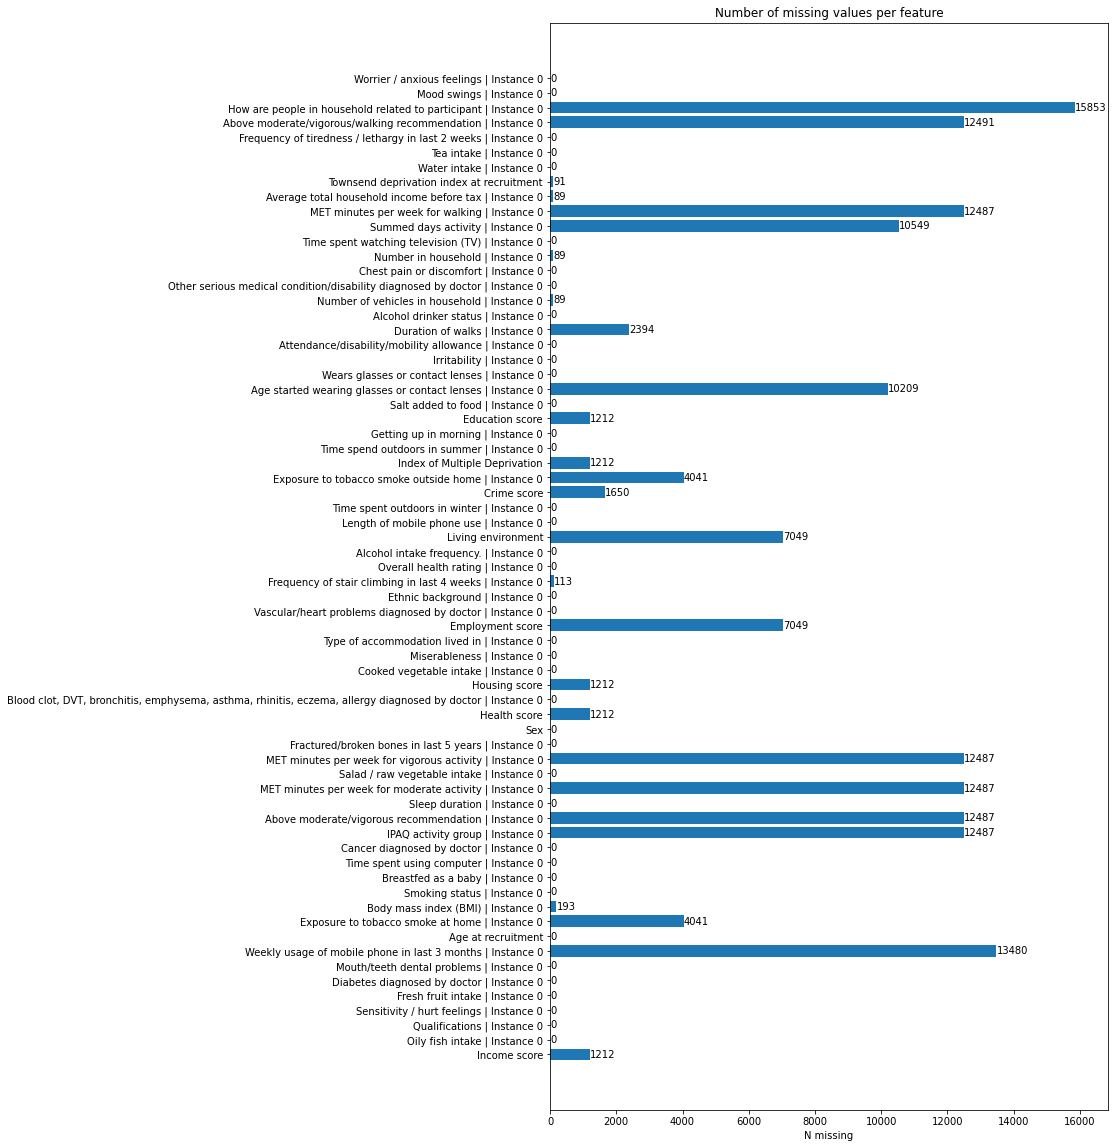

In [15]:
fig, ax = plt.subplots(figsize=(10,20))

col_names = list(X.columns)
y_pos = np.arange(len(col_names))

hbars = ax.barh(y_pos, n_missing, align='center')
ax.set_yticks(y_pos, labels=col_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('N missing')
ax.set_title('Number of missing values per feature')

# Label with specially formatted floats
ax.bar_label(hbars, fmt='%d')
ax.set_xlim(right=np.max(n_missing)+1000)  # adjust xlim to fit labels

plt.show()

## Numeric vs. categorical variables 
We select a subset of the data. Since some of the variables are categorical and others are numerical in nature, we need to deal with them slightly differently. To get a numeric encoding for categorical variables, we can use one-hot encoding. There are also many missing variables so we do mean and mode imputation. 

In [16]:
from accel.read_data import select_sets
from accel.constants import DEMO, PHYSICAL

In [17]:
other_factors = {
    'Alcohol drinker status | Instance 0',
    'Smoking status | Instance 0',
    'Time spend outdoors in summer | Instance 0',
    'Time spent outdoors in winter | Instance 0',
    'Time spent watching television (TV) | Instance 0',
    'Time spent using computer | Instance 0',
    'Health score',
    'Education score',
    'Employment score',
    'Income score',
    'Housing score',
}

In [18]:
X = select_sets(raw_data, DEMO, PHYSICAL, other_factors)

In [19]:
# checking the encoding
for col in X:
    print(col, X[col].dtype)

IPAQ activity group | Instance 0 object
Ethnic background | Instance 0 object
Frequency of stair climbing in last 4 weeks | Instance 0 object
Employment score float64
Above moderate/vigorous/walking recommendation | Instance 0 object
Time spent using computer | Instance 0 object
Body mass index (BMI) | Instance 0 float64
Smoking status | Instance 0 object
Education score float64
Time spend outdoors in summer | Instance 0 object
Housing score float64
Age at recruitment int64
MET minutes per week for walking | Instance 0 float64
Sex object
Summed days activity | Instance 0 float64
Health score float64
Time spent watching television (TV) | Instance 0 object
MET minutes per week for vigorous activity | Instance 0 float64
Time spent outdoors in winter | Instance 0 object
MET minutes per week for moderate activity | Instance 0 float64
Alcohol drinker status | Instance 0 object
Above moderate/vigorous recommendation | Instance 0 object
Duration of walks | Instance 0 object
Income score float6

As we see, a few variables have been encoded in ways we need to be careful of. These are:
- xFrequency of stair climbing in last 4 weeks | Instance 0 object
- xDuration of walks | Instance 0 *object* - this should just be the minutes spent walking (i.e. a number)
- xTime spent using computer | Instance 0 object
- xTime spent outdoors in winter | Instance 0 object - this and below should just be numbers (hours)
- xTime spend outdoors in summer | Instance 0 object
- Time spent watching television (TV) | Instance 0 object

In [20]:
issue_cols = ["Frequency of stair climbing in last 4 weeks | Instance 0",
             "Duration of walks | Instance 0",
             "Time spent using computer | Instance 0",
             "Time spent outdoors in winter | Instance 0",
             "Time spend outdoors in summer | Instance 0",
             "Time spent watching television (TV) | Instance 0"]

|Frequency of stair climbing in last 4 weeks | Instance 0|


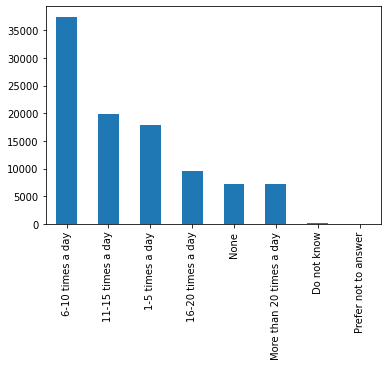

['1-5 times a day' '11-15 times a day' '16-20 times a day'
 '6-10 times a day' 'More than 20 times a day' 'None' nan 'Do not know'
 'Prefer not to answer']
|Duration of walks | Instance 0|


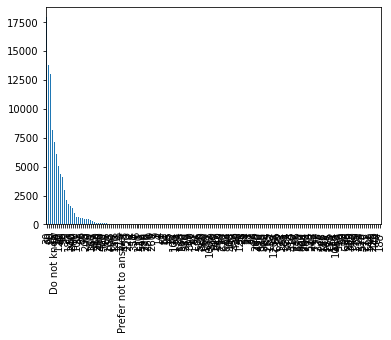

['40' '30' '60' '20' '120' '180' nan '240' '15' '10' '75' '90' '300' '100'
 '45' '80' 'Do not know' '25' '35' '360' '50' '70' '5' '99' '480' '400'
 '220' '720' '150' '170' '65' '12' '160' '210' '130' '55' '600' '11' '200'
 '500' '36' '250' '8' '42' '18' '6' '85' '59' '49' '140' '420' '22' '1000'
 'Prefer not to answer' '1' '110' '105' '3' '350' '48' '112' '72' '2'
 '450' '7' '260' '14' '182' '310' '280' '0' '270' '190' '880' '13' '530'
 '4' '800' '28' '540' '123' '9' '145' '84' '33' '17' '430' '16' '24' '58'
 '1200' '125' '510' '320' '520' '66' '19' '135' '550' '840' '315' '560'
 '46' '650' '27' '340' '95' '620' '453' '265' '900' '235' '700' '118'
 '1080' '54' '950' '62' '37' '660' '230' '53' '960' '380' '750' '330'
 '175' '69' '23' '325' '44' '275' '121' '144' '460' '490' '38' '226' '440'
 '64' '290' '52' '155' '820' '185' '82' '26' '385' '34' '39' '63' '21'
 '410' '96' '630' '580' '375' '204' '780' '74' '570' '246' '43' '732'
 '225' '77' '245' '115' '188']
|Time spent using computer 

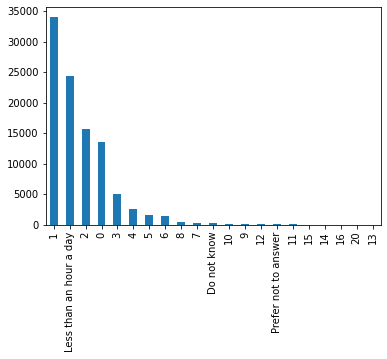

['1' '2' 'Less than an hour a day' '0' '3' '5' '4' 'Do not know' '6' '12'
 '16' '11' '7' '9' '8' 'Prefer not to answer' '10' '14' '20' '15' '13']
|Time spent outdoors in winter | Instance 0|


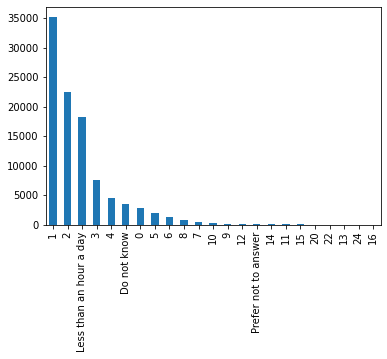

['2' '3' 'Less than an hour a day' '1' '10' '6' '4' 'Do not know' '8' '5'
 '0' '7' '12' '9' '15' '14' 'Prefer not to answer' '11' '20' '13' '22'
 '24' '16']
|Time spend outdoors in summer | Instance 0|


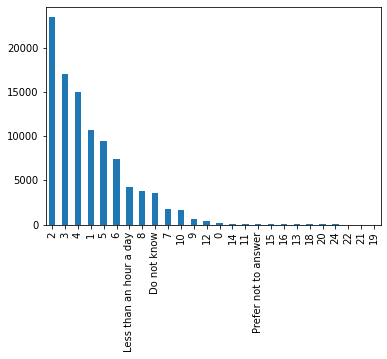

['8' '6' '1' '3' '2' '10' '5' '4' 'Less than an hour a day' 'Do not know'
 '9' '12' '7' '16' '0' '14' '13' '15' '24' '18' '11' '20'
 'Prefer not to answer' '22' '21' '19']
|Time spent watching television (TV) | Instance 0|


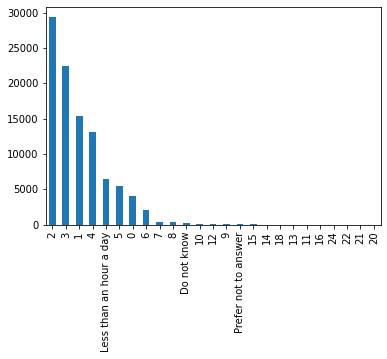

['6' '4' '3' '0' '2' 'Less than an hour a day' '1' '5' '12' '7'
 'Do not know' '8' 'Prefer not to answer' '16' '14' '10' '9' '22' '15'
 '24' '18' '13' '21' '11' '20']


In [21]:
for col in issue_cols:
    print("|",col,"|",sep="")
    X[col].value_counts().plot(kind='bar')
    plt.show()
    print(X[col].unique())

We provide custom encodings for the numeric columns which have been interpreted as categorical variables by encoding the strings, e.g. Do not know, as numerical values. These custome encodings are in the `read_data.py` script. We apply them below and then re-examine the variables.

In [22]:
from accel.read_data import custom_encodings, get_numeric_cols, get_object_cols

In [23]:
X = custom_encodings(X)

|Frequency of stair climbing in last 4 weeks | Instance 0|


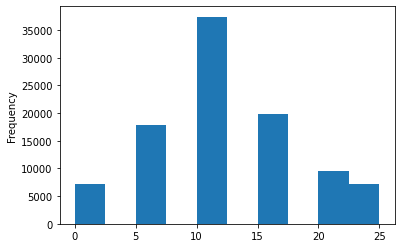

|Duration of walks | Instance 0|


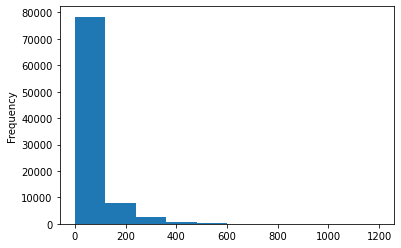

|Time spent using computer | Instance 0|


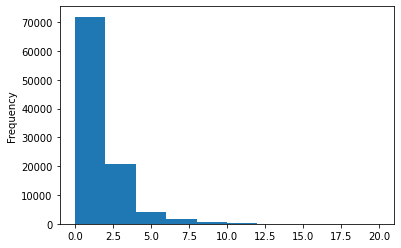

|Time spent outdoors in winter | Instance 0|


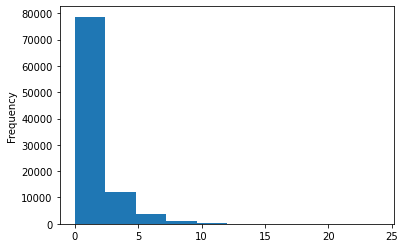

|Time spend outdoors in summer | Instance 0|


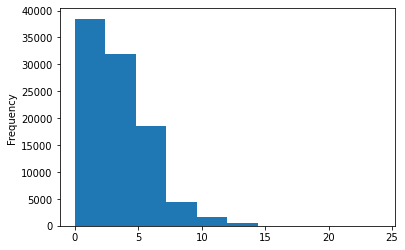

|Time spent watching television (TV) | Instance 0|


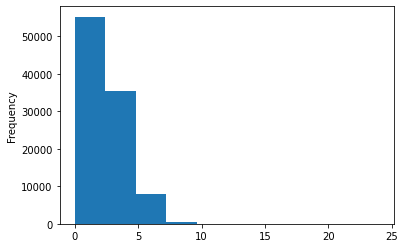

In [24]:
for col in issue_cols:
    print("|",col,"|",sep="")
    X[col].plot(kind='hist')
    plt.show()

In [25]:
for col in X:
    print(col)

IPAQ activity group | Instance 0
Ethnic background | Instance 0
Frequency of stair climbing in last 4 weeks | Instance 0
Employment score
Above moderate/vigorous/walking recommendation | Instance 0
Time spent using computer | Instance 0
Body mass index (BMI) | Instance 0
Smoking status | Instance 0
Education score
Time spend outdoors in summer | Instance 0
Housing score
Age at recruitment
MET minutes per week for walking | Instance 0
Sex
Summed days activity | Instance 0
Health score
Time spent watching television (TV) | Instance 0
MET minutes per week for vigorous activity | Instance 0
Time spent outdoors in winter | Instance 0
MET minutes per week for moderate activity | Instance 0
Alcohol drinker status | Instance 0
Above moderate/vigorous recommendation | Instance 0
Duration of walks | Instance 0
Income score


In [26]:
cat_feats = get_object_cols(X)
num_feats = get_numeric_cols(X)
cat_feats, num_feats

(['IPAQ activity group | Instance 0',
  'Ethnic background | Instance 0',
  'Above moderate/vigorous/walking recommendation | Instance 0',
  'Smoking status | Instance 0',
  'Sex',
  'Alcohol drinker status | Instance 0',
  'Above moderate/vigorous recommendation | Instance 0'],
 ['Frequency of stair climbing in last 4 weeks | Instance 0',
  'Employment score',
  'Time spent using computer | Instance 0',
  'Body mass index (BMI) | Instance 0',
  'Education score',
  'Time spend outdoors in summer | Instance 0',
  'Housing score',
  'Age at recruitment',
  'MET minutes per week for walking | Instance 0',
  'Summed days activity | Instance 0',
  'Health score',
  'Time spent watching television (TV) | Instance 0',
  'MET minutes per week for vigorous activity | Instance 0',
  'Time spent outdoors in winter | Instance 0',
  'MET minutes per week for moderate activity | Instance 0',
  'Duration of walks | Instance 0',
  'Income score'])

In [27]:
for feat in cat_feats:
    print(feat, X[feat].unique())

IPAQ activity group | Instance 0 ['moderate' 'high' 'low' nan]
Ethnic background | Instance 0 ['British' 'Any other white background' 'Irish' 'White and Asian'
 'Other ethnic group' 'Caribbean' 'Chinese' 'Indian'
 'Any other Asian background' 'Pakistani' 'White and Black African'
 'Any other mixed background' 'African' 'White and Black Caribbean'
 'Prefer not to answer' 'White' 'Do not know' 'Any other Black background'
 'Bangladeshi' 'Asian or Asian British' 'Mixed' 'Black or Black British']
Above moderate/vigorous/walking recommendation | Instance 0 ['Yes' 'No' nan]
Smoking status | Instance 0 ['Never' 'Previous' 'Current' 'Prefer not to answer']
Sex ['Female' 'Male']
Alcohol drinker status | Instance 0 ['Current' 'Never' 'Previous' 'Prefer not to answer']
Above moderate/vigorous recommendation | Instance 0 ['Yes' 'No' nan]


## Mean / mode imputation for numerical / categorical variables

In [28]:
# illustration of what's happening
ex = pd.DataFrame({"a" : [1,2,None,4], "b" : ["fish", "fish", "cat", None]})
ex["b"].fillna(ex["b"].mode().iloc[0], inplace=True)
ex["a"].fillna(ex["a"].mean(), inplace=True) # ask Jiazheng about median vs mean

In [29]:
for col in X.columns:
    if col in num_feats:
        # numeric columns
        X[col].fillna(X[col].mean(), inplace=True)
    elif col in categorical_features:
        # categorical columns
        X[col].fillna(X[col].mode().iloc[0], inplace=True)
    else:
        print('Unclear column:', col)

In [30]:
X.isna().sum() # no longer any missing values 

IPAQ activity group | Instance 0                               0
Ethnic background | Instance 0                                 0
Frequency of stair climbing in last 4 weeks | Instance 0       0
Employment score                                               0
Above moderate/vigorous/walking recommendation | Instance 0    0
Time spent using computer | Instance 0                         0
Body mass index (BMI) | Instance 0                             0
Smoking status | Instance 0                                    0
Education score                                                0
Time spend outdoors in summer | Instance 0                     0
Housing score                                                  0
Age at recruitment                                             0
MET minutes per week for walking | Instance 0                  0
Sex                                                            0
Summed days activity | Instance 0                              0
Health score             

## Encoding categorical variables
Some categorical have binary encodings, whereas others we will have to one-hot encode using one-hot encoding. We can achieve the one-hot encoding as follows:

In [31]:
X_enc = pd.get_dummies(X, columns=cat_feats)

# Thus far

- We have learnt how to cutoff extreme y-values. 
- We have explored the missingness in the data-set.
- We have learnt how to apply custom encodings to numerical and categorical data

To make life easier, we have implemented a `prep_data` function which loads data in from the file_path, removes entries with anomalous responses, applies custom encodings and applies mean/mode imputation depending on type of variable (though without allowing data leakage). Optionally, it applies one-hot encoding. Following this, standardise the numerical values, and divide the data into 

In [32]:
from accel.read_data import prep_data

In [33]:
X_train, X_val, X_test, y_train, y_val, y_test, means_modes = prep_data(DATA_DIR / "shared/reduced-cohort.csv", sets=(DEMO, PHYSICAL, other_factors))

In [34]:
X_train.shape, X_val.shape, X_test.shape

((69567, 24), (14907, 24), (14908, 24))

In [35]:
X_train.isna().sum(), X_val.isna().sum(), X_test.isna().sum()

(IPAQ activity group | Instance 0                               0
 Ethnic background | Instance 0                                 0
 Frequency of stair climbing in last 4 weeks | Instance 0       0
 Employment score                                               0
 Above moderate/vigorous/walking recommendation | Instance 0    0
 Time spent using computer | Instance 0                         0
 Body mass index (BMI) | Instance 0                             0
 Smoking status | Instance 0                                    0
 Education score                                                0
 Time spend outdoors in summer | Instance 0                     0
 Housing score                                                  0
 Age at recruitment                                             0
 MET minutes per week for walking | Instance 0                  0
 Sex                                                            0
 Summed days activity | Instance 0                              0
 Health sc

In [1]:
for col in cat_feats:
    print(col)
    X_train[col].value_counts().plot(kind='bar')
    plt.show()
    
print("========Numerical variables=========")
for col in num_feats:
    print(col)
    X_train[col].plot(kind='hist', bins=100)
    plt.show()

NameError: name 'cat_feats' is not defined

## Relationship to response
We now want to move onto exploring correlations in our data, and plot the relationships between the pairs of data and our response. 

In [50]:
# add y_vals back to training
df_train = X_train.assign(y=y_train.values)

In [69]:
len(df_train["Sex"].unique())

2

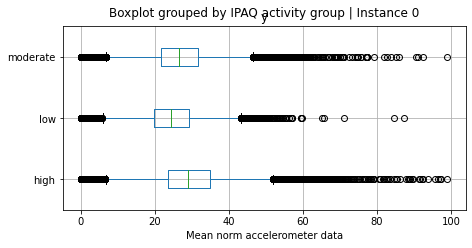

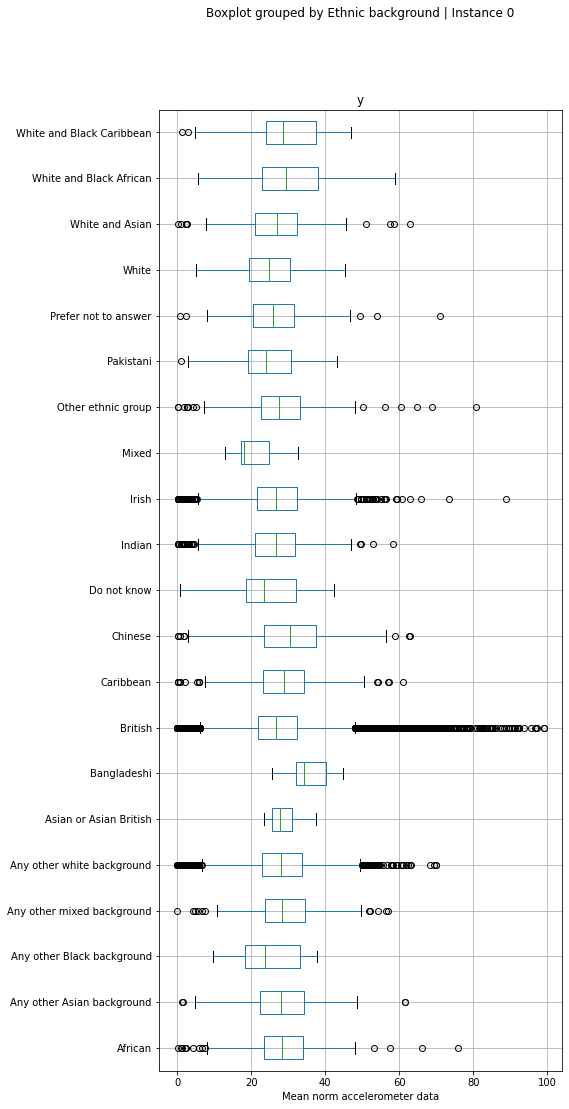

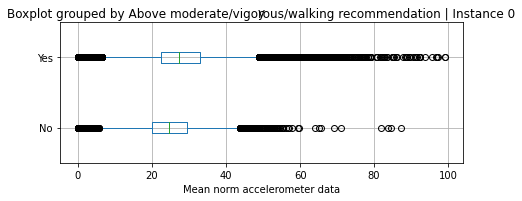

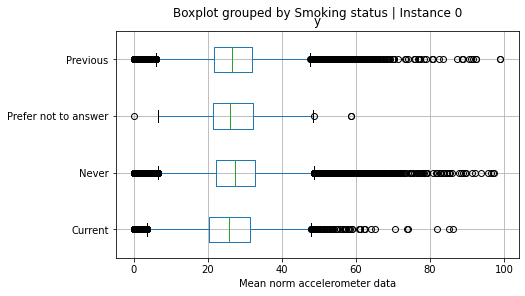

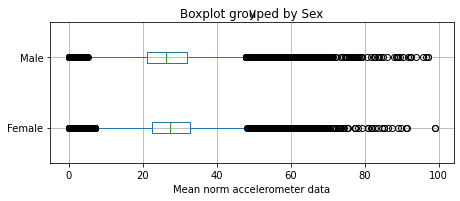

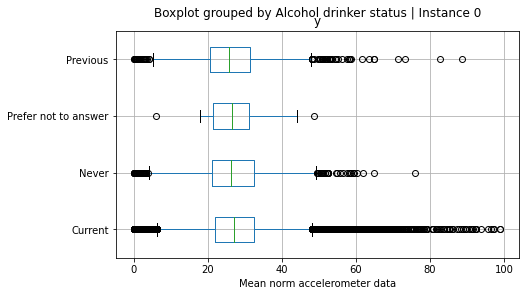

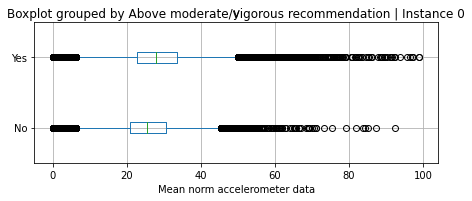

In [80]:
for col in df_train:
    if col in cat_feats:
        n_factors = len(df_train[col].unique())
        ax = df_train.boxplot("y", by=col, figsize=(7, 1 + 0.8*n_factors), vert=False)
        ax.set_xlabel("Mean norm accelerometer data")
        plt.show()

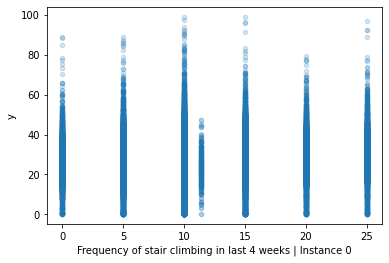

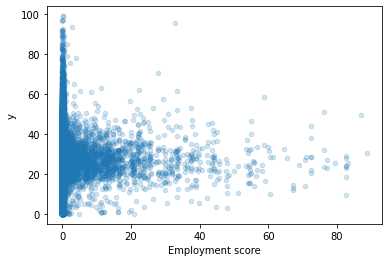

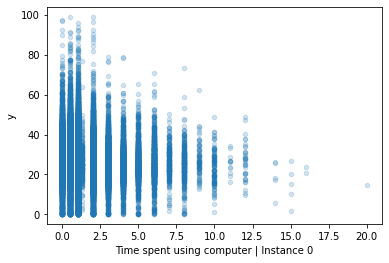

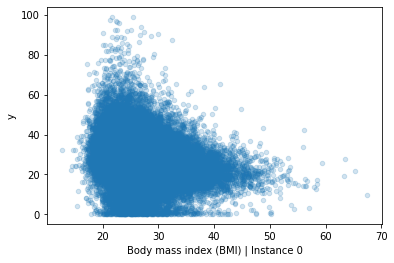

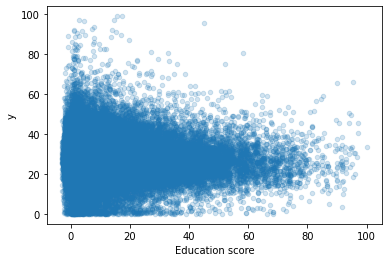

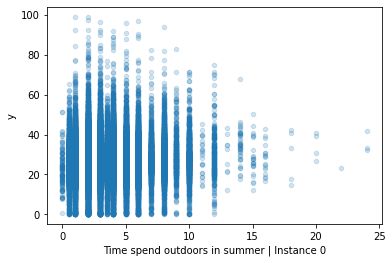

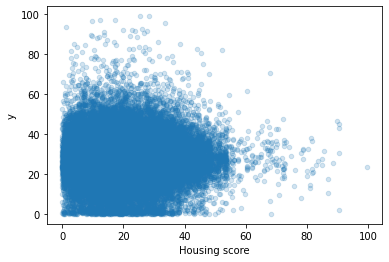

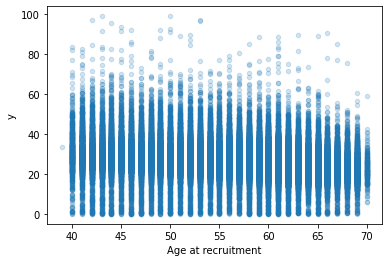

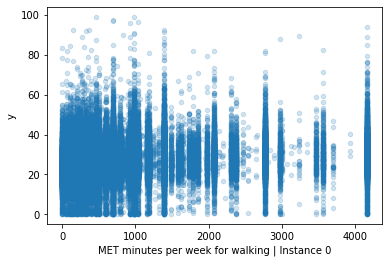

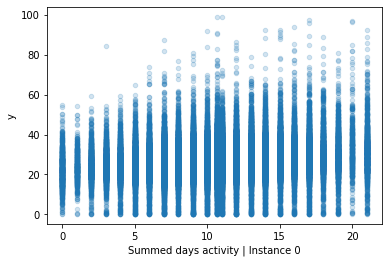

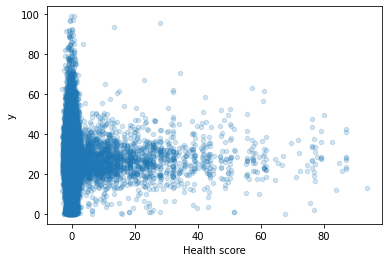

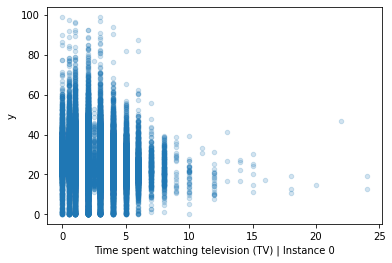

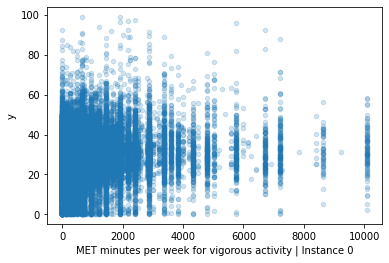

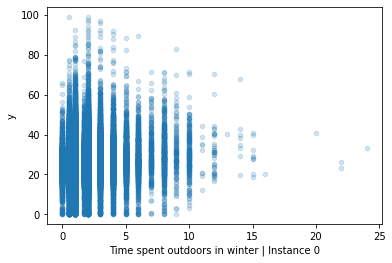

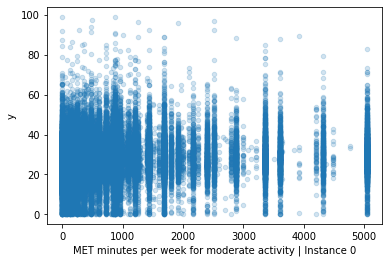

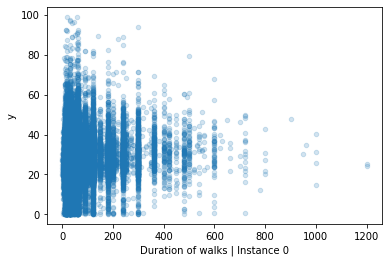

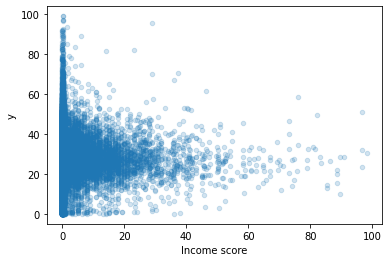

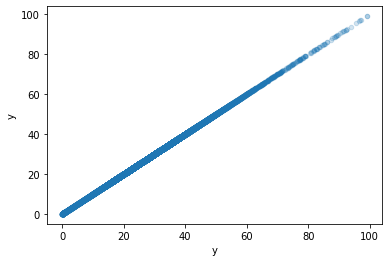

In [76]:
for col in df_train:
    if col in num_feats:
        df_train.plot.scatter(col, "y", alpha=1/5, )

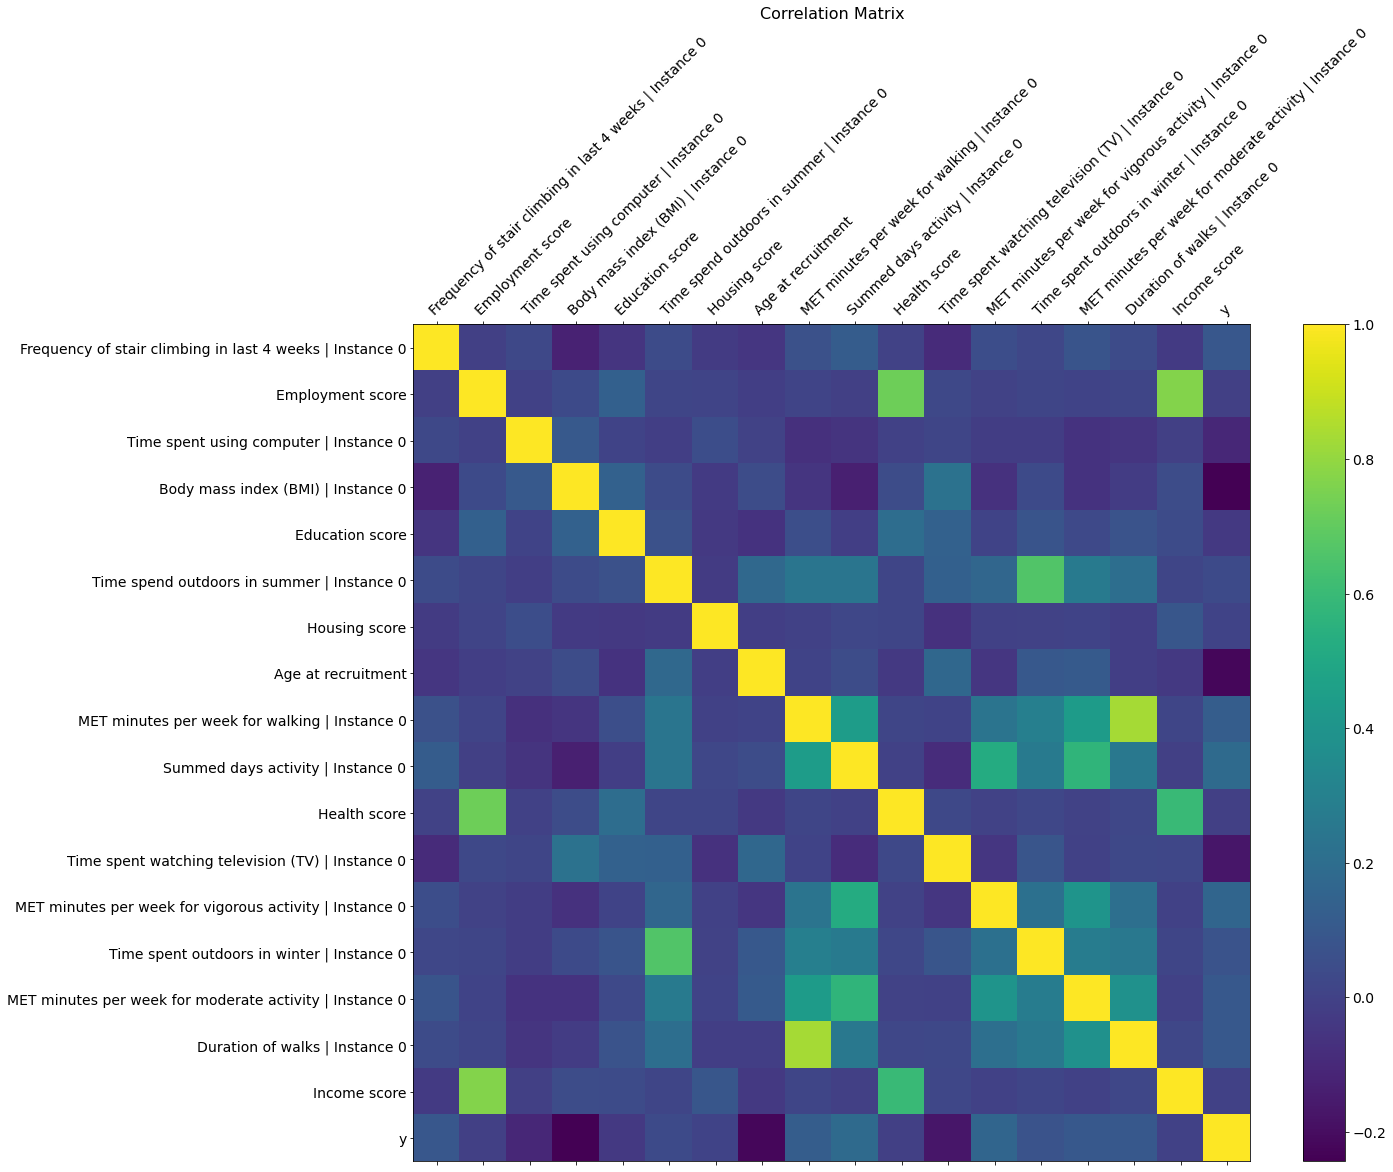

In [53]:
num_feats = get_numeric_cols(df_train)
f = plt.figure(figsize=(19, 15))
plt.matshow(df_train[num_feats].corr(), fignum=f.number)
plt.xticks(range(len(num_feats)), num_feats, fontsize=14, rotation=45, rotation_mode='anchor', ha='left')
plt.yticks(range(len(num_feats)), num_feats, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)